## VOCs

In [145]:
#tensorflow GPU 사용 확인
from tensorflow.python.client import device_lib
import pandas as pd
import numpy as np
import glob
from functools import reduce
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17045352062131704522
xla_global_id: -1
]


## 데이터 불러오기 및 정리

### VOCs 데이터

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#VOCs 데이터 불러오기

voc_data = pd.DataFrame()
year = [2019, 2020, 2021]
for k in year:
  for f in glob.glob(f'/content/drive/My Drive/final_paper/busan_traffic_/voc_{k}.xlsx'):
      df = pd.read_excel(f, index_col = 0)
      # 월, 일, 시간만 나와있어 연도 추가해 연월일시간의 새로운 date column 생성 예정
      df['연도'] = k
      voc_data = voc_data.append(df, ignore_index=True)

voc_data.head()

,월,일,시간,암모니아\n(ppb),톨루엔\n(ppb),mp-자일렌(ppb),o-자일렌(ppb),자일렌(ppb),메틸에틸케톤(ppb),벤젠(ppb),연도
0,1,1,0,76.1,2.8,0.8,0.3,1.1,0,0.4,2019
1,1,1,1,72.5,2.6,0.5,0.2,0.7,0,0.4,2019
2,1,1,2,70.1,2.5,0.5,0.2,0.7,0,0.4,2019
3,1,1,3,67.5,2.5,0.5,0.2,0.7,0,0.4,2019
4,1,1,4,68.8,1.5,0.4,0.1,0.6,0,0.4,2019


In [4]:
# 에러코드가 N/A값으로 처리되지 않아 2개
voc_data.isnull().sum().sum()

2

In [5]:
#voc_data 내의 에러코드를 정의한 후 에러코드를 N/A값으로 변경하기 -> 이후에 drop 예정
error_ms = ['동불', '점검', '동작불가', '전원단절', '전단', '가중', 'dks ehl']

for e in error_ms:
  for f in voc_data.columns:
    voc_data[f] = voc_data[f].replace(e, np.nan)

In [6]:
# 에러코드 N/A로 바꾼 후 늘어난 N/A 값
voc_data.isnull().sum().sum()

9926

### 기상 & 대기질 데이터

#### 대기질 데이터

In [7]:
# AIR DATA (BUSAN 2016-2020) 대기질 데이터
air = pd.read_excel('/content/drive/My Drive/final_paper/busan_traffic_/air_data_traffic.xlsx', index_col = 0)
air_2021 = pd.read_excel('/content/drive/My Drive/final_paper/busan_traffic_/air_2021_df.xlsx', index_col = 0)
print(air.columns)
print(air_2021.columns)
air.shape, air_2021.shape

Index(['측정일시', 'SO2', 'O3', 'NO2', 'PM25'], dtype='object')
Index(['date', 'PM25', 'O3', 'NO2', 'SO2'], dtype='object')


((17544, 5), (8760, 5))

In [8]:
# 2021 데이터에 맞추어 columns 수정하기
air.columns = ['date','SO2','O3','NO2','PM25']
air = air[['date','PM25','O3','NO2','SO2']]

In [9]:
# 2016-2021까지 데이터 합치기
air_data = pd.concat([air, air_2021]).reset_index().drop('index', axis = 1)
air_data.head(3)

,date,PM25,O3,NO2,SO2
0,2019010101,23.0,0.010,0.025,0.003
1,2019010102,21.0,0.012,0.021,0.003
2,2019010103,19.0,0.012,0.021,0.003


In [10]:
#DNN에 이용할 다음날 PM2.5 -> 새로운 변수로 생성
tomm_pm = air_data['PM25'][24:].reset_index()
air_data['tomm_pm'] = tomm_pm['PM25']
air_data.head(3)

,date,PM25,O3,NO2,SO2,tomm_pm
0,2019010101,23.0,0.010,0.025,0.003,22.0
1,2019010102,21.0,0.012,0.021,0.003,27.0
2,2019010103,19.0,0.012,0.021,0.003,21.0


###### ASOS DATA

In [11]:
# ASOS DATA (Busan) 기상데이터

all_data = pd.DataFrame()
for f in glob.glob('/content/drive/My Drive/final_paper/busan_traffic_/OBS_BUSAN_*.xlsx'):
    df = pd.read_excel(f)
    all_data = all_data.append(df, ignore_index=True)

all_data.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위),최저운고(100m ),시정(10m)
0,152,울산,2016-01-01 00:00:00,1.7,NaN,1.4,320.0,62.0,4.3,-4.8,1028.0,1032.4,NaN,NaN,0.0,0.0,NaN,1100.0
1,152,울산,2016-01-01 01:00:00,0.4,NaN,1.4,290.0,69.0,4.3,-4.6,1027.7,1032.1,NaN,NaN,NaN,NaN,NaN,900.0
2,152,울산,2016-01-01 02:00:00,-0.1,NaN,1.1,270.0,71.0,4.3,-4.7,1027.6,1032.0,NaN,NaN,NaN,NaN,NaN,900.0
3,152,울산,2016-01-01 03:00:00,0.0,NaN,1.4,320.0,69.0,4.2,-5.0,1027.5,1031.9,NaN,NaN,0.0,0.0,NaN,900.0
4,152,울산,2016-01-01 04:00:00,-0.7,NaN,1.3,290.0,74.0,4.3,-4.7,1027.5,1031.9,NaN,NaN,0.0,0.0,NaN,900.0


In [12]:
# 사용할 지점명만 선택(= 부산)
asos_data = all_data[all_data['지점명'] == '부산']

# 일시 dtype -> datetime으로 변경
asos_data['일시'] = pd.to_datetime(asos_data['일시'])

# 필요없는 컬럼 제거
asos_data.drop(['지점', '지점명'], axis = 1, inplace = True)

In [13]:
asos_data.isnull().sum()

일시                 0
기온(°C)             5
강수량(mm)        47516
풍속(m/s)           37
풍향(16방위)          37
습도(%)              0
증기압(hPa)           4
이슬점온도(°C)          6
현지기압(hPa)          8
해면기압(hPa)          5
일조(hr)         23951
일사(MJ/m2)      24856
전운량(10분위)       5089
중하층운량(10분위)     1241
최저운고(100m )    27523
시정(10m)           12
dtype: int64

In [14]:
# 전처리
# 강수량, 일조, 일사, 전운량, 중하층운량, 최저운고의 경우 N/A값은 측정되지 않은 값이 아니라 강수량이 없거나 일조량이 없는 등의 0의 값을 의미
# 따라서, N/A값을 0으로 변경
data_to0 = ['강수량(mm)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)', '중하층운량(10분위)', '최저운고(100m )']

for z in data_to0:
  asos_data[z] = asos_data[z].fillna(0)

# 기온, 풍속, 풍향, 증기압, 이슬점온도, 현지기압, 해면기압, 시정의 경우 측정에 오류가 생긴 값으로 선형보간법을 이용해 처리
data_ton = ['기온(°C)', '풍속(m/s)', '풍향(16방위)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '시정(10m)']
for n in data_ton:
  asos_data[n] = asos_data[n].interpolate(how = 'linear')

In [15]:
# 결측치가 모두 처리되었는지 확인
asos_data.isnull().sum()

일시             0
기온(°C)         0
강수량(mm)        0
풍속(m/s)        0
풍향(16방위)       0
습도(%)          0
증기압(hPa)       0
이슬점온도(°C)      0
현지기압(hPa)      0
해면기압(hPa)      0
일조(hr)         0
일사(MJ/m2)      0
전운량(10분위)      0
중하층운량(10분위)    0
최저운고(100m )    0
시정(10m)        0
dtype: int64

In [16]:
asos_data.describe()

,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위),최저운고(100m ),시정(10m)
count,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000
mean,15.464665,0.195138,3.134044,178.438545,63.466906,13.501487,7.870691,1007.472554,1015.724453,0.293180,0.601698,4.454798,2.786192,7.148304,2103.701025
std,8.516359,1.614325,1.764652,111.647222,20.673821,8.825711,11.714975,7.396053,7.649179,0.427835,0.925486,4.103320,3.470464,12.877324,1273.565305
min,-12.200000,0.000000,0.000000,0.000000,7.000000,0.600000,-29.000000,952.200000,959.700000,0.000000,0.000000,0.000000,0.000000,-99.000000,3.000000
25%,9.000000,0.000000,1.900000,70.000000,48.000000,6.000000,-0.200000,1001.900000,1009.900000,0.000000,0.000000,0.000000,0.000000,0.000000,1400.000000
50%,16.200000,0.000000,2.900000,200.000000,65.000000,11.600000,9.100000,1007.600000,1015.900000,0.000000,0.000000,4.000000,0.000000,0.000000,1998.000000
75%,22.200000,0.000000,4.000000,270.000000,80.000000,20.500000,17.900000,1013.200000,1021.700000,0.800000,1.010000,9.000000,6.000000,10.000000,2000.000000
max,36.600000,78.800000,18.500000,360.000000,100.000000,36.300000,27.300000,1027.100000,1036.000000,1.000000,4.770000,10.000000,10.000000,76.000000,5000.000000


In [17]:
ws = asos_data['풍속(m/s)']
wd = asos_data['풍향(16방위)']

Text(0, 0.5, 'Wind Velocity [m/s]')

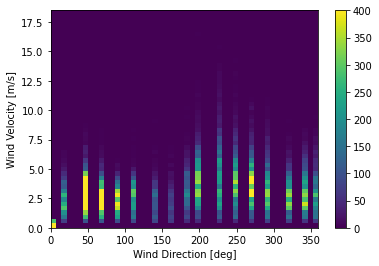

In [18]:
import matplotlib.pyplot as plt

plt.hist2d(wd, ws, bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [19]:
# 풍속과 풍향을 벡터화하여 표현
# 풍향의 0부터 360도를 나타내고 풍속이 없을 때 풍향의 값은 중요하지 않은 것을 표현하기 위하여
wv = asos_data.pop('풍속(m/s)')
wd_rad = asos_data.pop('풍향(16방위)')*np.pi / 180

asos_data['wind_x'] = wv*np.cos(wd_rad)
asos_data['wind_y'] = wv*np.sin(wd_rad)

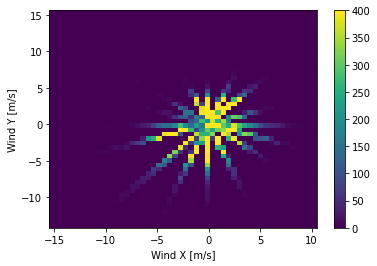

In [22]:
# 풍향과 풍속을 vector로 바꾼 후 그래프
plt.hist2d(asos_data['wind_x'], asos_data['wind_y'], bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
plt.show()

###### 전체 데이터 병합

In [21]:
# 접수날짜 to datetime
date_data = ['월', '일', '시간', '연도']
for d in date_data:
  voc_data[d] = voc_data[d].astype(str)

  voc_data[d] = voc_data[d].apply(lambda x : x.zfill(2))

In [23]:
voc_data['date'] = voc_data['연도'] + voc_data['월'] + voc_data['일'] + voc_data['시간'] + '000'
voc_data['date'] = pd.to_datetime(voc_data['date'], format = '%Y%m%d%H%M%S').dt.strftime('%Y-%m-%d %H:%M:%S')

In [24]:
#변경 후 연도, 월, 일, 시간 제거
voc_data.drop(['연도', '월', '일', '시간'], axis = 1, inplace = True)

#### 기상 데이터 + 대기 질 데이터 + vocs 데이터

##### 1. Air_data date 형식 변환 (%Y-%m-%d %H:%M:%S)

In [25]:
# 1. air_data date 형식 변환
air_data['date'] = air_data['date'].astype(str)

air_data['date'][:22632] # %Y%m%d%H 형태
air_data['date'][22632:] # %Y-%m-%d %H 형태

22632    2021-08-01:01
22633    2021-08-01:02
22634    2021-08-01:03
22635    2021-08-01:04
22636    2021-08-01:05
             ...      
26299    2021-12-31:20
26300    2021-12-31:21
26301    2021-12-31:22
26302    2021-12-31:23
26303    2021-12-31:24
Name: date, Length: 3672, dtype: object

In [26]:
#air_data(19년부터 21년 7월까지) 시간 01~24에서 00~23으로 변경
air_data['date'][:22632] # %Y%m%d%H 형태
air_data['date'][:22632] =air_data['date'][:22632].astype(str).str[:8] + air_data['date'][:22632].astype(str).str[8:].astype(int).apply(lambda x : x-1).astype(str).apply(lambda x : x.zfill(2))

In [27]:
air_data['date'][22632:].astype(str).str[11:13].astype(int).apply(lambda x : x-1).astype(str).apply(lambda x : x.zfill(2))

22632    00
22633    01
22634    02
22635    03
22636    04
         ..
26299    19
26300    20
26301    21
26302    22
26303    23
Name: date, Length: 3672, dtype: object

In [28]:
air_data['date'][22632:] = air_data['date'][22632:].astype(str).str[:11] + air_data['date'][22632:].astype(str).str[11:13].astype(int).apply(lambda x : x-1 if x!=0 else x == 23).astype(str).apply(lambda x : x.zfill(2))

In [29]:
air_data['date'][22632:]

22632    2021-08-01:00
22633    2021-08-01:01
22634    2021-08-01:02
22635    2021-08-01:03
22636    2021-08-01:04
             ...      
26299    2021-12-31:19
26300    2021-12-31:20
26301    2021-12-31:21
26302    2021-12-31:22
26303    2021-12-31:23
Name: date, Length: 3672, dtype: object

In [30]:
air_data['date']

0           2019010100
1           2019010101
2           2019010102
3           2019010103
4           2019010104
             ...      
26299    2021-12-31:19
26300    2021-12-31:20
26301    2021-12-31:21
26302    2021-12-31:22
26303    2021-12-31:23
Name: date, Length: 26304, dtype: object

In [31]:
air_data['date'][:22632] = air_data['date'][:22632].apply(lambda x : x + '000')
air_data['date'][22632:] = air_data['date'][22632:].apply(lambda x : x + ':00:00')

In [32]:
air_data['date'][:22632] = pd.to_datetime(air_data['date'][:22632], format = '%Y%m%d%H%M%S').dt.strftime('%Y-%m-%d %H:%M:%S')
air_data['date'][22632:] = pd.to_datetime(air_data['date'][22632:], format = '%Y-%m-%d:%H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S')

In [33]:
air_data['date']

0        2019-01-01 00:00:00
1        2019-01-01 01:00:00
2        2019-01-01 02:00:00
3        2019-01-01 03:00:00
4        2019-01-01 04:00:00
                ...         
26299    2021-12-31 19:00:00
26300    2021-12-31 20:00:00
26301    2021-12-31 21:00:00
26302    2021-12-31 22:00:00
26303    2021-12-31 23:00:00
Name: date, Length: 26304, dtype: object

##### 2. asos_data(기상 데이터) 기간 2019년부터 2021년까지로 변경

In [34]:
# 일시를 기준으로 정렬 후 인덱스 reset 진행
asos_data = asos_data.sort_values(by = '일시')
asos_data.reset_index().drop('index', axis = 1, inplace = True)

In [35]:
# 2019년부터 2021년으로 변경
asos_data = asos_data[26304:].reset_index().drop('index', axis = 1)

In [36]:
asos_data.rename(columns = {'일시' : 'date'}, inplace = True)
asos_data['date'] = asos_data['date'].astype(str)

In [37]:
voc_data['date']

0        2019-01-01 00:00:00
1        2019-01-01 01:00:00
2        2019-01-01 02:00:00
3        2019-01-01 03:00:00
4        2019-01-01 04:00:00
                ...         
26299    2021-12-31 19:00:00
26300    2021-12-31 20:00:00
26301    2021-12-31 21:00:00
26302    2021-12-31 22:00:00
26303    2021-12-31 23:00:00
Name: date, Length: 26304, dtype: object

In [38]:
air_data['date']

0        2019-01-01 00:00:00
1        2019-01-01 01:00:00
2        2019-01-01 02:00:00
3        2019-01-01 03:00:00
4        2019-01-01 04:00:00
                ...         
26299    2021-12-31 19:00:00
26300    2021-12-31 20:00:00
26301    2021-12-31 21:00:00
26302    2021-12-31 22:00:00
26303    2021-12-31 23:00:00
Name: date, Length: 26304, dtype: object

##### 3. 세 데이터 결합

In [116]:
# 세 데이터를 합치기 위한 merge 이용
data_list = [air_data, asos_data, voc_data]

final_data = reduce(lambda x, y : pd.merge(x, y, on = 'date'), data_list)

In [117]:
# colab 폰트 문제로 컬럼명 영어로 변경

final_data.columns = ['date', 'PM25', 'O3', 'NO2', 'SO2', 'tomm_pm', 'tem', 'rain',
       'hum', 'vap_press', 'dew_point', 'press', 'sea_press', 'sunshine',
       'solar', 'cloud', 'cloud_mid', 'cloud_low', 'see',
       'wind_x', 'wind_y', 'ammonia', 'toluen', 'mp-xylen',
       'o-xylen', 'xylen', 'ketone', 'benzene']

In [118]:
# 다음 날 PM2.5와 vocs의 상관관계
voc_pm = final_data[['tomm_pm', 'ammonia', 'toluen', 'mp-xylen', 'o-xylen', 'xylen', 'ketone', 'benzene']].dropna(how = 'any')
asos_pm = final_data[['tomm_pm', 'tem', 'rain', 'hum', 'vap_press', 'dew_point', 'press', 'sea_press', 'sunshine',
       'solar', 'cloud', 'cloud_mid', 'cloud_low', 'see', 'wind_x', 'wind_y']].dropna(how = 'any')

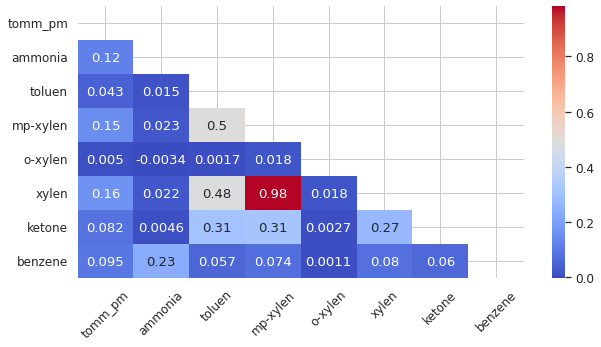

In [119]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(10,5))
heat_map_1 = voc_pm.corr()
mask_1 = np.zeros_like(heat_map_1)
mask_1[np.triu_indices_from(mask_1)] = True
heatmap_ax_1 = sns.heatmap(heat_map_1, annot=True, mask=mask_1, cmap='coolwarm')
heatmap_ax_1.set_xticklabels(heatmap_ax_1.get_xticklabels(), fontsize=12, rotation=45)
heatmap_ax_1.set_yticklabels(heatmap_ax_1.get_yticklabels(), fontsize=12)
plt.show()

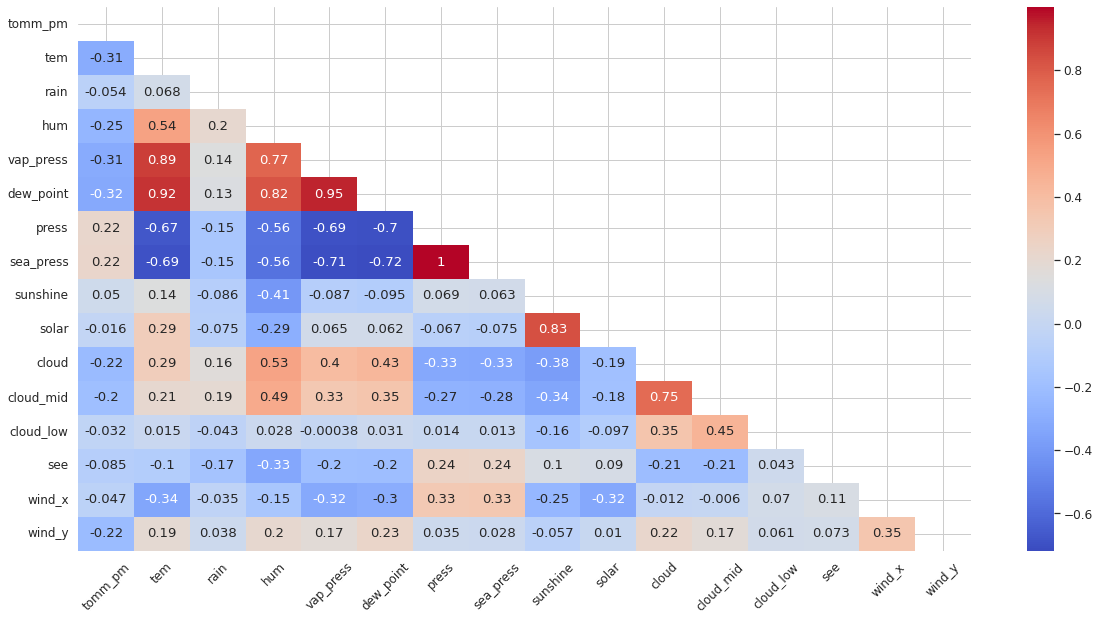

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(20,10))
heat_map_2 = asos_pm.corr()
mask_2 = np.zeros_like(heat_map_2)
mask_2[np.triu_indices_from(mask_2)] = True
heatmap_ax_2 = sns.heatmap(heat_map_2, annot = True, mask = mask_2, cmap = 'coolwarm')
heatmap_ax_2.set_xticklabels(heatmap_ax_2.get_xticklabels(), fontsize=12, rotation=45)
heatmap_ax_2.set_yticklabels(heatmap_ax_2.get_yticklabels(), fontsize=12)
plt.show()

In [121]:
# 절댓값을 취해 연관성이 낮은 순으로 정렬
score_corr = pd.DataFrame(abs(final_data.corr()['tomm_pm'])).sort_values(by = 'tomm_pm')

# 기존에 알려진 기작과 비교해 연관성이 낮은 것들을 제외하고 모두 제거 
# (o-xylen, solar, cloud_low, toluen, sunshine, ketone, see, benzene, mp-xylen), xylen은 결측치가 많은 것을 확인해 제외
final_data.drop(['o-xylen', 'solar', 'cloud_low', 'toluen', 'sunshine', 'ketone', 'see', 'benzene', 'mp-xylen', 'xylen'], axis = 1, inplace = True)
final_data.columns

Index(['date', 'PM25', 'O3', 'NO2', 'SO2', 'tomm_pm', 'tem', 'rain', 'hum',
       'vap_press', 'dew_point', 'press', 'sea_press', 'cloud', 'cloud_mid',
       'wind_x', 'wind_y', 'ammonia'],
      dtype='object')

In [122]:
graph_data = final_data.copy()
graph_data.set_index('date', inplace = True)
graph_data_1 = abs(graph_data.corr()['tomm_pm']).sort_values(ascending = False)

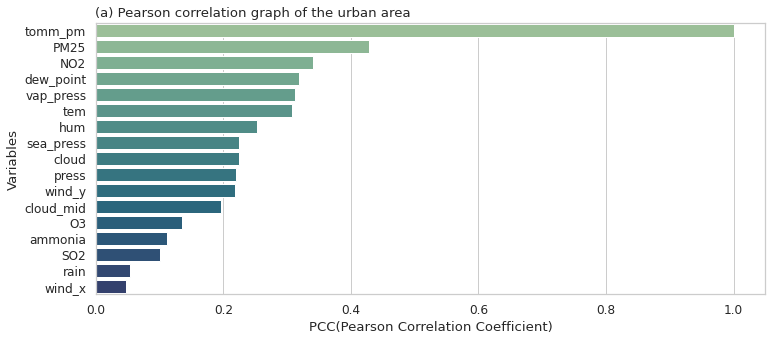

In [123]:
import seaborn as sns
plt.figure(figsize=(12,5))
sns.set(font_scale=1.1)
sns.set_style('whitegrid')
plt.xlabel('PCC(Pearson Correlation Coefficient)')
plt.ylabel('Variables')
plt.title('(a) Pearson correlation graph of the urban area',
          position = (0.235, 1.01))
sns.barplot(data = pd.DataFrame(graph_data_1).T, orient='h', palette = 'crest')
plt.show()

###### DATA

In [124]:
final_data

,date,PM25,O3,NO2,SO2,tomm_pm,tem,rain,hum,vap_press,dew_point,press,sea_press,cloud,cloud_mid,wind_x,wind_y,ammonia
0,2019-01-01 00:00:00,23.0,0.010,0.025,0.003,22.0,2.1,0.0,25.0,1.8,-15.9,1022.5,1031.3,3.0,3.0,1.778505,-4.886402,76.100
1,2019-01-01 01:00:00,21.0,0.012,0.021,0.003,27.0,1.0,0.0,25.0,1.6,-16.8,1022.8,1031.7,0.0,0.0,1.641697,-4.510525,72.500
2,2019-01-01 02:00:00,19.0,0.012,0.021,0.003,21.0,-0.1,0.0,26.0,1.6,-17.3,1022.3,1031.2,0.0,0.0,3.753618,-3.149659,70.100
3,2019-01-01 03:00:00,24.0,0.011,0.021,0.003,15.0,-0.9,0.0,28.0,1.6,-17.1,1022.5,1031.4,0.0,0.0,3.476863,-1.265475,67.500
4,2019-01-01 04:00:00,28.0,0.013,0.022,0.003,15.0,-1.2,0.0,31.0,1.7,-16.2,1022.2,1031.1,0.0,0.0,4.416555,-1.607495,68.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26269,2021-12-31 19:00:00,NaN,0.026,0.013,0.002,NaN,0.5,0.0,22.0,1.4,-18.8,1019.1,1028.0,0.0,0.0,1.532089,-1.285575,11.157
26270,2021-12-31 20:00:00,NaN,0.030,0.011,0.001,NaN,0.0,0.0,22.0,1.3,-19.2,1019.1,1028.0,0.0,0.0,1.685298,-1.414133,11.448
26271,2021-12-31 21:00:00,NaN,0.029,0.011,0.001,NaN,-0.4,0.0,23.0,1.4,-19.0,1018.7,1027.6,0.0,0.0,1.402283,-3.852740,10.654
26272,2021-12-31 22:00:00,NaN,0.032,0.009,0.001,NaN,-0.8,0.0,23.0,1.3,-19.4,1019.5,1028.4,0.0,0.0,-1.094464,-3.007016,10.940


In [125]:
# 결측치 확인 -> interpolate linear를 이용해 결측치 보간
final_data.isnull().sum()
# 결측치 보간 -> interpolate, linear 이용
final_data = final_data.interpolate(how = 'linear')

In [126]:
# 보간 후 결측치 확인
final_data.isnull().sum().sum()

0

In [137]:
#연월일시간의 단위는 의미있는 역할 x -> 초 단위로 변환
timestamp_s = pd.to_datetime(final_data['date']).map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

# 사인 및 코사인 변환을 사용하여 시간, 시간신호를 지우기 -> 사용 가능한 신호로 변환
final_data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
final_data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
final_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
final_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

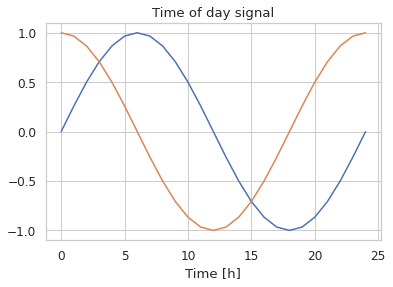

In [144]:
plt.plot(np.array(final_data['Day sin'])[:25])
plt.plot(np.array(final_data['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

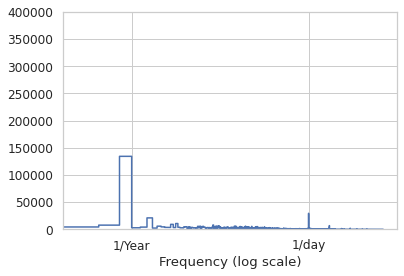

In [147]:
# 시간 경과에 따른 온도의 tf.signal.rfft 
# 1/year 및 1/day에 가까운 빈도에서 명백한 피크가 있다는 점을 확인 가능
fft = tf.signal.rfft(final_data['tem'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(final_data['tem'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [148]:
# Train, Vlidation, test set
final_data = final_data.reset_index().drop('index', axis = 1)

air_train = final_data[final_data['date'].astype(str).str[:4] == '2019']
air_valid = final_data[final_data['date'].astype(str).str[:4] == '2020']
air_test = final_data[final_data['date'].astype(str).str[:4] == '2021']

print(air_train.shape, air_valid.shape, air_test.shape)

(8730, 22) (8784, 22) (8760, 22)


In [149]:
#outlier 구하는 식
# 1) 신뢰구간 이용
def outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z].index
# 2) IQR (25% 에서 75% 사이의 값 이용하기)
def get_outlier(df=None, column=None, weight = 1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    outlier_idx = df[column][(df[column] < lowest) | (df[column] > highest)].index
    return outlier_idx

# !!!! outlier 구할 때 해당 column에 빈 값이 있으면 결과가 나오지 않음 dropna 이후에 진행하기.

In [150]:
# outlier는 딥러닝에서 보통 제거 하지 x
# 그래서 clip으로 값을 대체하기로 함
def outlier_clipping(df):
  for col in df.columns:

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = q3-q1

    low_limit = q3 + 1.5 * iqr
    high_limit = q1 - 1.5 * iqr

    df[f'{col}_outlier'] = df[col].apply(outlier, args = (low_limit, high_limit))
  return df

In [151]:
# outlier_IQR = get_outlier(df = air_test, column='PM25', weight=1.5)
# len(outlier_IQR)

# air_test = air_test.drop(outlier_IQR)
# air_test = air_test.reset_index()
# air_test = air_test.drop('index', axis=1)

In [152]:
air_train.columns

Index(['date', 'PM25', 'O3', 'NO2', 'SO2', 'tomm_pm', 'tem', 'rain', 'hum',
       'vap_press', 'dew_point', 'press', 'sea_press', 'cloud', 'cloud_mid',
       'wind_x', 'wind_y', 'ammonia', 'Day sin', 'Day cos', 'Year sin',
       'Year cos'],
      dtype='object')

In [153]:
dnn_x_train = air_train.drop(['date', 'tomm_pm'], axis = 1)
dnn_y_train = air_train[['PM25']]

dnn_x_valid = air_valid.drop(['date', 'tomm_pm'], axis = 1)
dnn_y_valid = air_valid[['PM25']]

dnn_x_test = air_test.drop(['date', 'tomm_pm'], axis = 1)
dnn_y_test = air_test[['PM25']]

In [154]:
#StandardScaler & MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

scaler.fit(dnn_x_train)

train_scaled = pd.DataFrame(scaler.transform(dnn_x_train))
valid_scaled = pd.DataFrame(scaler.transform(dnn_x_valid))
test_scaled = pd.DataFrame(scaler.transform(dnn_x_test))

In [156]:
train_scaled.shape, valid_scaled.shape, test_scaled.shape

((8730, 20), (8784, 20), (8760, 20))